In [38]:
import cv2
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

In [2]:
# video paths
CellA_GFP = './CellA_GFP.avi'
CellA_ShME480 = "./CellA_ShME480.avi"
CellB_GFP = './CellB_GFP.avi'
CellB_ME480 = './CellB_ME480.avi'


In [250]:
def process_video(video_path, display_video=False, display_velocity=50):
    cap = cv2.VideoCapture(video_path)
    
    # Get properties of the video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    ret = True
    frame_count = 1
    # create an empty dataframe to store the results
    table = pd.DataFrame(columns=['area', 'perimeter', 'major_axis', 'minor_axis', 'angle', 'circularity', 'aspect_ratio', 'roundness', 'solidity'])
    black = np.zeros((frame_height, 10, 3), np.uint8)
    text_screen = np.ones((frame_height, 160, 3), np.uint8)*255
    while ret:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        crop_width = int(frame_width * 0.20)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray_frame = gray_frame[:, crop_width:-crop_width]
        blur = cv2.GaussianBlur(gray_frame, (5,5),0)
    
        # Apply thresholding
        h, mask = cv2.threshold(blur, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        # apply erosion to fill in the holes
        kernel = np.ones((7, 7),np.uint8)
        mask = cv2.erode(mask,kernel,iterations = 2)
        mask = cv2.dilate(mask,kernel,iterations = 2)
        mask = cv2.bitwise_not(mask)
        mask = mask[:, crop_width:-crop_width]

        contours1, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        x_offset, y_offset = crop_width, 0
        contours = []
        for i, cont in enumerate(contours1):
            contours.append( cont + (x_offset, y_offset))

        # we select only frames with 2 contours (1 for the frame frame_countour, and 1 for the cell contour)
        if len(contours) > 0:
            gray_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
            # sort the contours by size to have the frame contour first, cell contour will always be smaller
            cnt = sorted(contours, key=cv2.contourArea, reverse=True) 
            
            # select the cell contour by size to get rid of noisy contours
            if  cv2.contourArea(cnt[0]) > 300 and cv2.contourArea(cnt[0]) < 9000:
                
                # contourIdx allows to choose the contour to draw
                cv2.drawContours(gray_frame, cnt, -1, color=(0,255,0), thickness=1)

                # fit an ellipse to the contour and draw it
                ellipse = cv2.fitEllipse(cnt[0])
                (xc, yc), (d1, d2), angle = ellipse
                
                # add the ellipse parameters to the dataframe
                columns=['area', 'perimeter', 'major_axis', 'minor_axis', 'angle', 'circularity', 'aspect_ratio', 'roundness', 'solidity']
                table.loc[frame_count] = [cv2.contourArea(cnt[0]), cv2.arcLength(cnt[0], True), max(d1,d2), min(d1,d2), angle, 4*np.pi*cv2.contourArea(cnt[0])/(cv2.arcLength(cnt[0], True)**2), max(d1,d2)/min(d1,d2), 4*cv2.contourArea(cnt[0])/(np.pi*max(d1,d2)**2), cv2.contourArea(cnt[0])/cv2.contourArea(cv2.convexHull(cnt[0]))]
           

                if display_video:
                    # draw the ellipse on the gray frame
                    cv2.ellipse(gray_frame, ellipse, (0,0,255), 1)

                    # transform mask to 3 channels to concatenate it with the frame
                    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
                    
                    # Display the resulting frames mask and gray_frame in the same window 
                    display = np.concatenate((text_screen, black, frame, black, mask, black, gray_frame), axis=1)

                    # add a text to the image
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(display, 'frame {}'.format(frame_count), (10, 20), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'area: {:.2f}'.format(cv2.contourArea(cnt[0])), (10, 40), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'perimeter: {:.2f}'.format(cv2.arcLength(cnt[0], True)), (10, 60), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'major_axis: {:.2f}'.format(max(d1,d2)), (10, 80), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'minor_axis: {:.2f}'.format(min(d1,d2)), (10, 100), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'angle: {:.2f}'.format(angle), (10, 120), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'circularity: {:.2f}'.format(4*np.pi*cv2.contourArea(cnt[0])/(cv2.arcLength(cnt[0], True)**2)), (10, 140), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'aspect_ratio: {:.2f}'.format(max(d1,d2)/min(d1,d2)), (10, 160), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'roundness: {:.2f}'.format(4*cv2.contourArea(cnt[0])/(np.pi*max(d1,d2)**2)), (10, 180), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    cv2.putText(display, 'solidity: {:.2f}'.format(cv2.contourArea(cnt[0])/cv2.contourArea(cv2.convexHull(cnt[0]))), (10, 200), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
                    
                    cv2.imshow('frame', display)
                    if cv2.waitKey(display_velocity) & 0xFF == ord('q'):
                         cv2.destroyAllWindows()
                         break

            frame_count += 1
            if not (frame_count % 1000):
                print(frame_count)
                
    cv2.destroyAllWindows()
    cap.release()
    return table


In [257]:
data_CellA_GFP= process_video(CellA_GFP)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [258]:
data_CellA_GFP.to_csv('data_CellA_GFP.csv')

In [253]:
data_CellA_ShME480 = process_video(CellA_ShME480)

1000
2000
3000
4000


In [255]:
data_CellA_ShME480.to_csv('data_CellA_ShME480.csv')

In [259]:
data_CellB_GFP = process_video(CellB_GFP)

1000
2000
3000
4000
5000
6000
7000


In [260]:
data_CellB_GFP.to_csv('data_CellB_GFP.csv')

In [262]:
data_CellB_ME480 = process_video(CellB_ME480) # TUNE PARAMETERS

1000
2000
3000
4000


In [263]:
data_CellB_ME480.to_csv('data_CellB_ME480.csv')

In [23]:
def boxplot_fig(data, col, title, y_label, y_lim):
    fig, ax = plt.subplots()
    ax.boxplot([i[col] for i in data], showmeans=True, meanline=True)
    ax.set_xticklabels(['A - ShME480', 'A - GFP', 'B - ME480', 'B - GFP'])
    ax.set_xlabel('Cell Type')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    # set a y limit
    ax.set_ylim(y_lim[0], y_lim[1])
    plt.show()

   Unnamed: 0    area   perimeter  major_axis  minor_axis       angle  \
0           1  1676.5  162.468036   59.753986   36.494442  179.946823   
1           2  1637.5  159.639609   58.407524   36.438431    0.165920   
2           3  1866.0  165.539104   58.338226   41.436169  179.333725   
3           4  2671.0  229.396969  102.411179   36.754181    0.452565   
4           5  2747.5  233.639609   93.976219   37.514420    0.882846   

   circularity  aspect_ratio  roundness  solidity  
0     0.798137      1.637345   0.597833  0.978121  
1     0.807439      1.602910   0.611158  0.977029  
2     0.855698      1.407906   0.698096  0.980557  
3     0.637835      2.786382   0.324257  0.960619  
4     0.632491      2.505069   0.396106  0.960664  


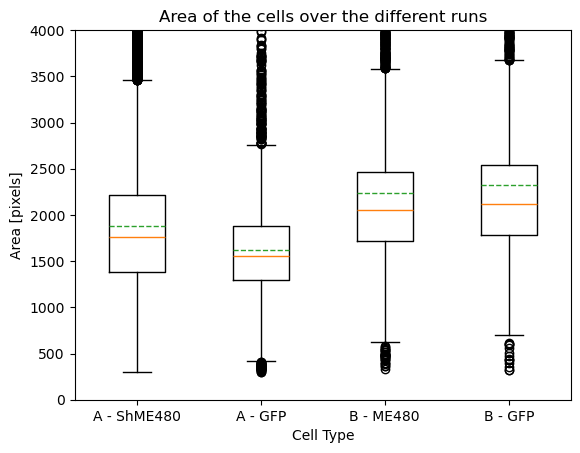

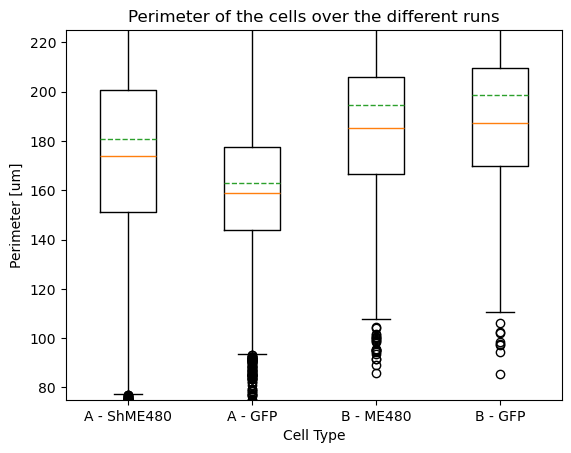

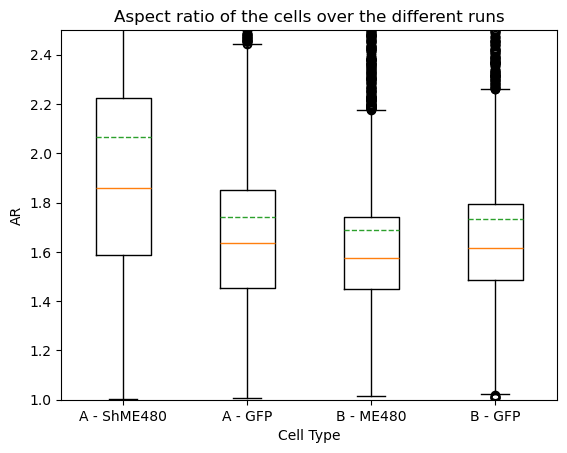

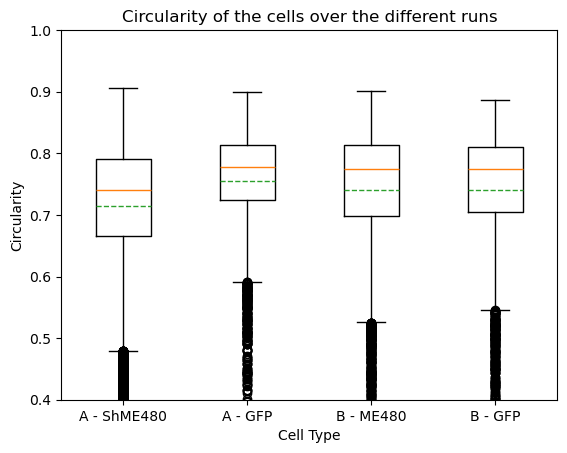

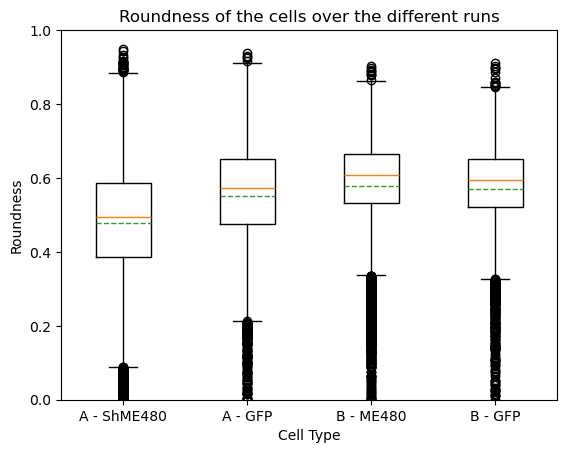

In [37]:
#Loading Data
csv_files = ['data_CellA_GFP.csv','data_CellA_ShME480.csv','data_CellB_GFP.csv','data_CellB_ME480.csv']

data = [pd.read_csv(i) for i in csv_files]
print(data[0].head())
boxplot_fig(data, 'area', 'Area of the cells over the different runs', 'Area [pixels]', (0, 4000))
boxplot_fig(data, 'perimeter', 'Perimeter of the cells over the different runs', 'Perimeter [um]', (75, 225))
boxplot_fig(data, 'aspect_ratio', 'Aspect ratio of the cells over the different runs', 'AR', (1, 2.5))
boxplot_fig(data, 'circularity', 'Circularity of the cells over the different runs', 'Circularity', (.4, 1))
boxplot_fig(data, 'roundness', 'Roundness of the cells over the different runs', 'Roundness', (0, 1))



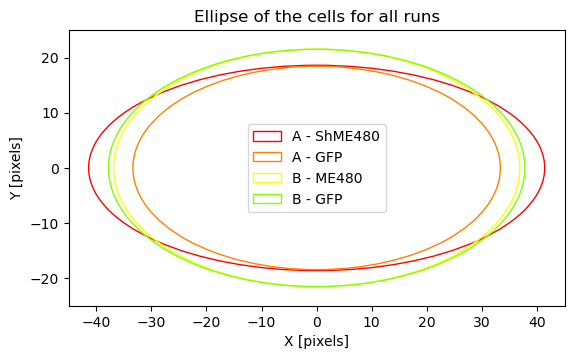

In [44]:
# plot an ellipse based on the mean value of the major and minor axis of the cells of run 1
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-45, 45)
ax.set_ylim(-25, 25)
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')
ax.set_title('Ellipse of the cells for all runs')
labels = ['A - ShME480', 'A - GFP', 'B - ME480', 'B - GFP']
# define a list of 8 colors in chromatic order
colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00']#, '#00ff00', '#00ff80', '#00ffff', '#0080ff']
for i,dat in enumerate(data):
    minor = dat['minor_axis'].mean()
    major = dat['major_axis'].mean()
    ellipse = Ellipse(xy=(0, 0), width=major, height=minor, edgecolor=colors[i], fc='None', lw=1, label=labels[i])
    ax.add_patch(ellipse)
ax.legend()
plt.show()
